# Model Quantization

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
#import os
#os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
# for this tutorial we wont be actually running Vivado, so I have commented these lines out
#     but if you want to look into actually running on an FPGA then simply uncomment these lines

## Fetch the jet tagging dataset from Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [4]:
model = Sequential()
model.add(QDense(64, input_shape=(16,), name='fc1',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(QDense(32, name='fc2',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(QDense(32, name='fc3',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(QDense(5, name='output',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

2022-07-26 21:04:31.560987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  mask = self.add_variable(
/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  threshold = self.add_variable(
/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.pruning_step = self.add_variable(


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_4')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_4/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_4/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30


/Users/drankin/miniconda3/envs/ml-latest/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


480/487 [============================>.] - ETA: 0s - loss: 1.3881 - accuracy: 0.4900
***callbacks***
saving losses to model_4/losses.log

Epoch 1: val_loss improved from inf to 1.19395, saving model to model_4/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.19395, saving model to model_4/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_4/KERAS_check_model_last.h5

Epoch 1: saving model to model_4/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 5s 5ms/step - loss: 1.3854 - accuracy: 0.4916 - val_loss: 1.1940 - val_accuracy: 0.6129 - lr: 1.0000e-04
Epoch 2/30
479/487 [============================>.] - ETA: 0s - loss: 1.1089 - accuracy: 0.6524
***callbacks***
saving losses to model_4/losses.log

Epoch 2: val_loss improved from 1.19395 to 1.04657, saving model to model_4/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.19395 to 1.04657, saving model to model_4/KERAS_check_best_model_weights.


Epoch 13: saving model to model_4/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.8275 - accuracy: 0.7308 - val_loss: 0.8247 - val_accuracy: 0.7308 - lr: 1.0000e-04
Epoch 14/30
480/487 [============================>.] - ETA: 0s - loss: 0.8162 - accuracy: 0.7326
***callbacks***
saving losses to model_4/losses.log

Epoch 14: val_loss improved from 0.82468 to 0.81405, saving model to model_4/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 0.82468 to 0.81405, saving model to model_4/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_4/KERAS_check_model_last.h5

Epoch 14: saving model to model_4/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.8160 - accuracy: 0.7326 - val_loss: 0.8141 - val_accuracy: 0.7329 - lr: 1.0000e-04
Epoch 15/30
487/487 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.7345

Epoch 26/30
484/487 [============================>.] - ETA: 0s - loss: 0.7570 - accuracy: 0.7462
***callbacks***
saving losses to model_4/losses.log

Epoch 26: val_loss improved from 0.76249 to 0.76052, saving model to model_4/KERAS_check_best_model.h5

Epoch 26: val_loss improved from 0.76249 to 0.76052, saving model to model_4/KERAS_check_best_model_weights.h5

Epoch 26: saving model to model_4/KERAS_check_model_last.h5

Epoch 26: saving model to model_4/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 0.7571 - accuracy: 0.7462 - val_loss: 0.7605 - val_accuracy: 0.7450 - lr: 1.0000e-04
Epoch 27/30
486/487 [============================>.] - ETA: 0s - loss: 0.7554 - accuracy: 0.7467
***callbacks***
saving losses to model_4/losses.log

Epoch 27: val_loss improved from 0.76052 to 0.75954, saving model to model_4/KERAS_check_best_model.h5

Epoch 27: val_loss improved from 0.76052 to 0.75954, saving model to model_4/KERA

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [35]:
import hls4ml
import plotting
hls4ml.model.optimizer.optimizer_pass('output_rounding_saturation_mode').layers = ['Activation']
hls4ml.model.optimizer.optimizer_pass('output_rounding_saturation_mode').rounding_mode = 'AP_RND'
hls4ml.model.optimizer.optimizer_pass('output_rounding_saturation_mode').saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_4/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: QDense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: QActivation
  -> Activation (quantized_relu), layer name: relu1
Layer name: fc2, layer type: QDense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: QActivation
  -> Activation (quantized_relu), layer name: relu2
Layer name: fc3, layer type: QDense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: QActivation
  -> Activation (quantized_relu), layer name: relu3
Layer name: output, layer type: QDense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  fc1_input
    Precision
      result:        ap_fixed<16,6>
  fc1
    Precision
      weight:        ap_fixed<6,1>
      bias:          

5188/5188 [==============================] - 4s 704us/step
Accuracy baseline:  0.7502650602409638
Accuracy pruned, quantized: 0.7454819277108434
Accuracy hls4ml: 0.5828132530120482


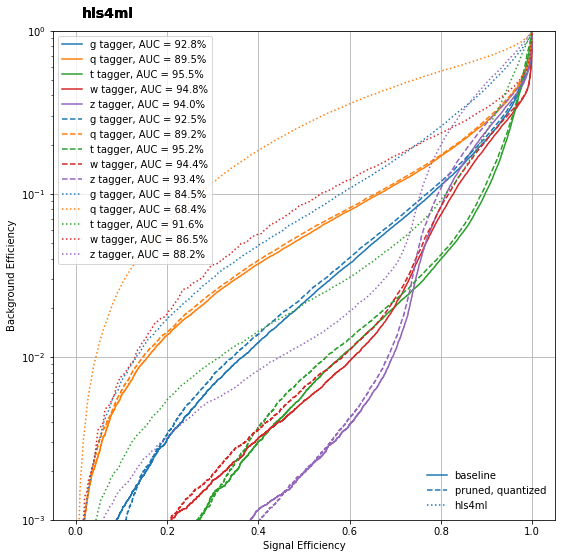

In [36]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

# Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj/vivado_hls.log`

In [ ]:
hls_model.build(csim=False)

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [ ]:
hls4ml.report.read_vivado_report('model_3/hls4ml_prj')

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vivado HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [ ]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj')

## NB
Note as well that the Vivado HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.